<a href="https://colab.research.google.com/github/Jaimemorillo/Pointwise-ML-Ranking/blob/main/Pointwise_LOINC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Three-category label

Load libraries

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

Read the 3 datasets (one per query)

In [66]:
df_glucose = pd.read_csv('loinc_dataset-glucose-in-blood.csv', sep=';')
df_bilirubin = pd.read_csv('loinc_dataset-bilirubin-in-plasma.csv', sep=';')
df_white_blood_cells = pd.read_csv('loinc_dataset-white-blood-cells-count.csv', sep=';')

Concatenate them

In [67]:
df = pd.concat([df_glucose, df_bilirubin, df_white_blood_cells])
df = df.reset_index(drop=True)

In [68]:
print('Original shape: ' + str(df.shape))
display(df.head(5))

Original shape: (246, 8)


,loinc_num,long_common_name,component,system,property,label_binary,label_3_cat,query
0,1988-5,C reactive protein [Mass/volume] in Serum or P...,C reactive protein,Ser/Plas,MCnc,0,0,GLUCOSE IN BLOOD
1,1959-6,Bicarbonate [Moles/volume] in Blood,Bicarbonate,Bld,SCnc,0,1,GLUCOSE IN BLOOD
2,10331-7,Rh [Type] in Blood,Rh,Bld,Type,0,1,GLUCOSE IN BLOOD
3,18998-5,Trimethoprim+Sulfamethoxazole [Susceptibility],Trimethoprim+Sulfamethoxazole,Isolate,Susc,0,0,GLUCOSE IN BLOOD
4,1975-2,Bilirubin.total [Mass/volume] in Serum or Plasma,Bilirubin,Ser/Plas,MCnc,0,0,GLUCOSE IN BLOOD


### Features

Keeped features:
- **long_common_name**: will be encoded applying tf-idf
- **system**: one-hot encoded
- **property**: one-hot encoded
- **query**: will be encoded with the similarity between query and the document

Labels (created manually):
- **label_binary**: 0 non relevant & 1 relevant
- **label_3_cat**: 0 non relevant, 1 some relevant & 2 relevant



In [69]:
drop_columns = ['loinc_num', 'component']
df = df.drop(drop_columns, axis=1)

df = pd.get_dummies(df, columns=['system', 'property'], drop_first=False)

First 5 rows

In [70]:
display(df.head(5))

,long_common_name,label_binary,label_3_cat,query,system_Bld,system_BldA,system_BldC,system_BldV,system_Bld^BPU,system_Calculus,...,property_NCnc,property_NFr,property_NFr.DF,property_Num,property_PrThr,property_SCnc,property_Susc,property_Temp,property_Type,property_VFr
0,C reactive protein [Mass/volume] in Serum or P...,0,0,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bicarbonate [Moles/volume] in Blood,0,1,GLUCOSE IN BLOOD,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Rh [Type] in Blood,0,1,GLUCOSE IN BLOOD,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Trimethoprim+Sulfamethoxazole [Susceptibility],0,0,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Bilirubin.total [Mass/volume] in Serum or Plasma,0,0,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Distribution of the labels in each query

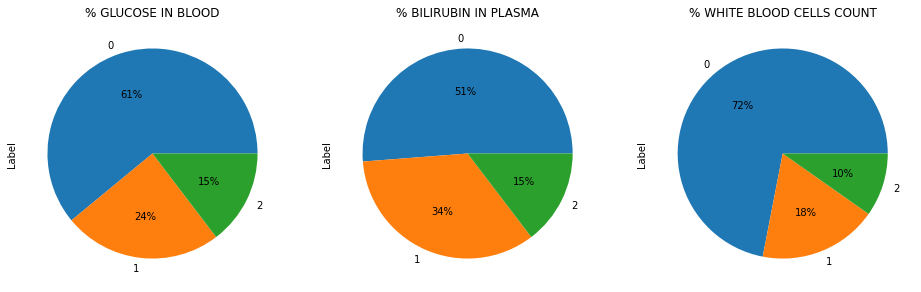

In [71]:
fig, axes = plt.subplots(1,3, figsize=(16, 5))
plot1 = df[df['query']=='GLUCOSE IN BLOOD'].label_3_cat.value_counts(normalize=True).plot.pie(autopct='%1.0f%%', 
                                                                                      ax = axes[0], 
                                                                                      title='% GLUCOSE IN BLOOD', 
                                                                                      ylabel='Label')
plot2 = df[df['query']=='BILIRUBIN IN PLASMA'].label_3_cat.value_counts(normalize=True).plot.pie(autopct='%1.0f%%', 
                                                                                      ax = axes[1], 
                                                                                      title='% BILIRUBIN IN PLASMA', 
                                                                                      ylabel='Label')
plot3 = df[df['query']=='WHITE BLOOD CELLS COUNT'].label_3_cat.value_counts(normalize=True).plot.pie(autopct='%1.0f%%', 
                                                                                      ax = axes[2], 
                                                                                      title='% WHITE BLOOD CELLS COUNT', 
                                                                                      ylabel='Label')

# Text Processing

Preprocessing techniques applied:
- Lower-case text.
- Cleaning up special characters.
- Removing extra whitespaces.
- Removing stopwords.
- Stemming.


In [72]:
class Normalizer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.ps = PorterStemmer() # Create Stemmer
        self.word_net = WordNetLemmatizer() #Create Lemmatizer
    
    def remove_punct(self, text):
        text = text.lower() # To lower case
        text = re.sub('\W', ' ', text) # Replace any character which is not a word character
        text = re.sub('\s+', ' ', text) # Replace any whitespace character
        text = re.sub(' +', ' ', text) # Replace multiple whitespaces
        text = text.strip() # Delete sorrounding whitespaces
        return text
    
    def tokenize(self, text):
        return word_tokenize(text)
    
    def remove_stop_words(self, tokens):
        return [word for word in tokens if not word in self.stop_words] 
    
    def stemming(self, tokens):
        return [self.ps.stem(word) for word in tokens]
    
    def lemmatize(self, tokens):
        return [self.word_net.lemmatize(word) for word in tokens]
    
    def return_sentences(self, tokens):
        return " ".join(tokens)
    
    def clean_all(self, text):
        text = self.remove_punct(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stop_words(tokens)
        tokens = self.stemming(tokens)
        text = self.return_sentences(tokens)
        return text

In [73]:
df_final = df.copy()

In [74]:
norm = Normalizer()
df_final['long_common_name'] = df_final['long_common_name'].progress_apply(lambda x: norm.clean_all(x))

  0%|          | 0/246 [00:00<?, ?it/s]

First 5 rows after normalization

In [75]:
df_final.head(5)

,long_common_name,label_binary,label_3_cat,query,system_Bld,system_BldA,system_BldC,system_BldV,system_Bld^BPU,system_Calculus,...,property_NCnc,property_NFr,property_NFr.DF,property_Num,property_PrThr,property_SCnc,property_Susc,property_Temp,property_Type,property_VFr
0,c reactiv protein mass volum serum plasma,0,0,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,bicarbon mole volum blood,0,1,GLUCOSE IN BLOOD,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,rh type blood,0,1,GLUCOSE IN BLOOD,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,trimethoprim sulfamethoxazol suscept,0,0,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,bilirubin total mass volum serum plasma,0,0,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split Train and Test

Train (80%) and Test (20%). Stratified to maintain the proportion of the labels and of the querys


In [76]:
X = df_final.drop(['label_binary','label_3_cat'], axis=1)
y = df_final['label_3_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=1, 
                                                    stratify=df_final[['label_3_cat', 'query']])
print('Shape train: ' + str(X_train.shape))
print('Shape test: ' + str(X_test.shape))

Shape train: (196, 37)
Shape test: (50, 37)


### Text encoding - TF-IDF
Apply Tf-Idf strategy to encode long_common_name

Ignore words that appear in less than 5 documents


In [77]:
tfidf = TfidfVectorizer(max_df=1.0, min_df=5, use_idf=True, smooth_idf=True, sublinear_tf=True)
X_train_enc = tfidf.fit_transform(X_train['long_common_name'])
X_test_enc = tfidf.transform(X_test['long_common_name'])

X_train_enc = pd.DataFrame.sparse.from_spmatrix(X_train_enc, index = X_train.index)
X_test_enc = pd.DataFrame.sparse.from_spmatrix(X_test_enc, index = X_test.index)

print('Size of the Vocabulary: ' + str(X_train_enc.shape[1]))
print('Original: ' + X_train.iloc[0, 0])
print('Encoded: ' + str(X_train_enc.iloc[0].to_numpy()))

Size of the Vocabulary: 34
Original: fast glucos mass mole volum serum plasma
Encoded: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.54661332 0.         0.         0.         0.         0.
 0.         0.40417471 0.4771834  0.3406685  0.         0.
 0.         0.         0.         0.33852609 0.         0.
 0.         0.         0.         0.28195345]


Paste the query column to tf-idf features

In [78]:
X_train = X_train.join(X_train_enc)
X_train_enc['query'] = X_train['query']
X_test = X_test.join(X_test_enc)
X_test_enc['query'] = X_test['query']

### Query similarity
Calculate the similarity between the document vector and the query vector (cos similarity)

In [79]:
def query_similarity(documents, query):
  query = norm.clean_all(query)
  query_enc = tfidf.transform([query])

  documents_similarity = cosine_similarity(query_enc, documents)
  documents_similarity = documents_similarity.T

  return documents_similarity

Apply similairy to train

In [80]:
X_train_enc_glucose = X_train_enc[X_train_enc['query']=='GLUCOSE IN BLOOD'].drop('query', axis=1)
X_train_enc_glucose['query_similarity'] = query_similarity(X_train_enc_glucose, 'GLUCOSE IN BLOOD')

X_train_enc_bilirubin = X_train_enc[X_train_enc['query']=='BILIRUBIN IN PLASMA'].drop('query', axis=1)
X_train_enc_bilirubin['query_similarity'] = query_similarity(X_train_enc_bilirubin, 'BILIRUBIN IN PLASMA')

X_train_enc_white = X_train_enc[X_train_enc['query']=='WHITE BLOOD CELLS COUNT'].drop('query', axis=1)
X_train_enc_white['query_similarity'] = query_similarity(X_train_enc_white, 'WHITE BLOOD CELLS COUNT')

In [81]:
X_train_enc = pd.concat([X_train_enc_glucose, X_train_enc_bilirubin, X_train_enc_white])
X_train = X_train.join(X_train_enc['query_similarity'])

Apply similairy to test

In [82]:
X_test_enc_glucose = X_test_enc[X_test_enc['query']=='GLUCOSE IN BLOOD'].drop('query', axis=1)
X_test_enc_glucose['query_similarity'] = query_similarity(X_test_enc_glucose, 'GLUCOSE IN BLOOD')

X_test_enc_bilirubin = X_test_enc[X_test_enc['query']=='BILIRUBIN IN PLASMA'].drop('query', axis=1)
X_test_enc_bilirubin['query_similarity'] = query_similarity(X_test_enc_bilirubin, 'BILIRUBIN IN PLASMA')

X_test_enc_white = X_test_enc[X_test_enc['query']=='WHITE BLOOD CELLS COUNT'].drop('query', axis=1)
X_test_enc_white['query_similarity'] = query_similarity(X_test_enc_white, 'WHITE BLOOD CELLS COUNT')

In [83]:
X_test_enc = pd.concat([X_test_enc_glucose, X_test_enc_bilirubin, X_test_enc_white])
X_test = X_test.join(X_test_enc['query_similarity'])

First 5 rows of the trainning dataset

In [84]:
sample = X_train.drop(['long_common_name', 'query'], axis=1)
print('Final trainning shape: ' + str(sample.shape))
display(sample.head(5))

Final trainning shape: (196, 70)


,system_Bld,system_BldA,system_BldC,system_BldV,system_Bld^BPU,system_Calculus,system_Dose,system_Isolate,system_Plas,system_Plr fld,...,25,26,27,28,29,30,31,32,33,query_similarity
55,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.338526,0.000000,0.0,0.0,0.0,0.0,0.281953,0.447229
158,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.386947,0.000000,0.0,0.0,0.0,0.0,0.322282,0.730052
87,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,0.000000
31,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.236253,0.587594,0.0,0.0,0.0,0.0,0.000000,0.000000
109,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,0.000000


# Models

## Regression

Solve the ranking as a regression problem. Predicting continuous values. This keeps the order of the target labels

In [85]:
reg = ElasticNetCV(cv=X_train.shape[0], random_state=1) #Leave one out
reg.fit(X_train.drop(['long_common_name', 'query'], axis=1).values, y_train)

ElasticNetCV(cv=196, random_state=1)

In [86]:
preds = reg.predict(X_test.drop(['long_common_name', 'query'], axis=1).values)

In [87]:
results = {
    'name': X_test['long_common_name'],
    'real' : y_test,
    'score' : preds,
    'query': X_test['query']
}

results = pd.DataFrame(results)

In [88]:
results[results['query']=='GLUCOSE IN BLOOD'].sort_values('score', ascending=False)

,name,real,score,query
68,glucos mass volum blood,2,2.483975,GLUCOSE IN BLOOD
19,glucos mole volum pleural fluid,2,1.755783,GLUCOSE IN BLOOD
33,monocyt volum blood,1,1.498123,GLUCOSE IN BLOOD
6,carbon dioxid total mole volum blood,1,0.900282,GLUCOSE IN BLOOD
37,abo group type blood,1,0.812153,GLUCOSE IN BLOOD
77,smudg cell leukocyt pure number fraction blood...,1,0.735164,GLUCOSE IN BLOOD
5,blood group antibodi screen presenc serum plasma,0,0.654191,GLUCOSE IN BLOOD
36,major crossmatch interpret,0,0.260160,GLUCOSE IN BLOOD
49,carcinoembryon ag mass volum serum plasma,0,0.252827,GLUCOSE IN BLOOD
65,calcium mole volum correct albumin serum plasma,0,0.221274,GLUCOSE IN BLOOD


In [89]:
results[results['query']=='BILIRUBIN IN PLASMA'].sort_values('score', ascending=False)

,name,real,score,query
154,bilirubin conjug indirect mass volum serum plasma,2,1.700394,BILIRUBIN IN PLASMA
110,bilirubin indirect mass volum serum plasma,2,1.700394,BILIRUBIN IN PLASMA
116,carcinoembryon ag mass volum serum plasma,1,0.979419,BILIRUBIN IN PLASMA
145,cholesterol hdl mass volum serum plasma,1,0.979419,BILIRUBIN IN PLASMA
140,chlorid mole volum serum plasma,1,0.903019,BILIRUBIN IN PLASMA
105,calcium mass volum serum plasma,1,0.759312,BILIRUBIN IN PLASMA
137,alkalin phosphatas enzymat activ volum serum p...,1,0.631769,BILIRUBIN IN PLASMA
130,choriogonadotropin unit volum serum plasma,1,0.622259,BILIRUBIN IN PLASMA
108,abo group type blood,0,0.364690,BILIRUBIN IN PLASMA
98,rh type blood,0,0.359234,BILIRUBIN IN PLASMA


In [90]:
results[results['query']=='WHITE BLOOD CELLS COUNT'].sort_values('score', ascending=False)

,name,real,score,query
241,smudg cell leukocyt pure number fraction blood...,2,2.365161,WHITE BLOOD CELLS COUNT
244,lymphoma cell 100 leukocyt blood manual count,2,2.181654,WHITE BLOOD CELLS COUNT
188,chlorid mole volum blood,1,0.793290,WHITE BLOOD CELLS COUNT
197,carbon dioxid total mole volum blood,1,0.656880,WHITE BLOOD CELLS COUNT
210,glucos mass volum serum plasma blood,1,0.555091,WHITE BLOOD CELLS COUNT
176,fast glucos mass mole volum serum plasma,0,0.317463,WHITE BLOOD CELLS COUNT
177,cholesterol hdl mass volum serum plasma,0,0.252827,WHITE BLOOD CELLS COUNT
170,aspart aminotransferas enzymat activ volum ser...,0,0.221274,WHITE BLOOD CELLS COUNT
189,choriogonadotropin beta subunit mole volum ser...,0,0.221274,WHITE BLOOD CELLS COUNT
229,alanin aminotransferas enzymat activ volum ser...,0,0.221274,WHITE BLOOD CELLS COUNT


## Classification
Solve the ranking as a classification problem. Predicting discrete values (0,1 & 2). This does not keeps the order of the target labels

In [91]:
clf = LogisticRegressionCV(cv=26, random_state=1, max_iter=1000) # the least populated class in y has only 14 members
clf.fit(X_train.drop(['long_common_name', 'query'], axis=1).values, y_train)

LogisticRegressionCV(cv=26, max_iter=1000, random_state=1)

In [92]:
preds = clf.predict(X_test.drop(['long_common_name', 'query'], axis=1).values)

In [93]:
results = {
    'name': X_test['long_common_name'],
    'real' : y_test,
    'pred' : preds,
    'query': X_test['query']
}

results = pd.DataFrame(results)

In [94]:
results[results['query']=='GLUCOSE IN BLOOD'].sort_values('pred', ascending=False)

,name,real,pred,query
68,glucos mass volum blood,2,2,GLUCOSE IN BLOOD
19,glucos mole volum pleural fluid,2,2,GLUCOSE IN BLOOD
37,abo group type blood,1,1,GLUCOSE IN BLOOD
6,carbon dioxid total mole volum blood,1,1,GLUCOSE IN BLOOD
33,monocyt volum blood,1,1,GLUCOSE IN BLOOD
77,smudg cell leukocyt pure number fraction blood...,1,1,GLUCOSE IN BLOOD
5,blood group antibodi screen presenc serum plasma,0,1,GLUCOSE IN BLOOD
65,calcium mole volum correct albumin serum plasma,0,0,GLUCOSE IN BLOOD
49,carcinoembryon ag mass volum serum plasma,0,0,GLUCOSE IN BLOOD
10,protein c mass volum plasma,0,0,GLUCOSE IN BLOOD


In [95]:
results[results['query']=='BILIRUBIN IN PLASMA'].sort_values('pred', ascending=False)

,name,real,pred,query
154,bilirubin conjug indirect mass volum serum plasma,2,2,BILIRUBIN IN PLASMA
110,bilirubin indirect mass volum serum plasma,2,2,BILIRUBIN IN PLASMA
130,choriogonadotropin unit volum serum plasma,1,1,BILIRUBIN IN PLASMA
137,alkalin phosphatas enzymat activ volum serum p...,1,1,BILIRUBIN IN PLASMA
116,carcinoembryon ag mass volum serum plasma,1,1,BILIRUBIN IN PLASMA
105,calcium mass volum serum plasma,1,1,BILIRUBIN IN PLASMA
140,chlorid mole volum serum plasma,1,1,BILIRUBIN IN PLASMA
145,cholesterol hdl mass volum serum plasma,1,1,BILIRUBIN IN PLASMA
88,methicillin resist staphylococcu aureu presenc...,0,0,BILIRUBIN IN PLASMA
104,abo group type blood blood product unit,0,0,BILIRUBIN IN PLASMA


In [96]:
results[results['query']=='WHITE BLOOD CELLS COUNT'].sort_values('pred', ascending=False)

,name,real,pred,query
241,smudg cell leukocyt pure number fraction blood...,2,2,WHITE BLOOD CELLS COUNT
244,lymphoma cell 100 leukocyt blood manual count,2,2,WHITE BLOOD CELLS COUNT
197,carbon dioxid total mole volum blood,1,1,WHITE BLOOD CELLS COUNT
210,glucos mass volum serum plasma blood,1,1,WHITE BLOOD CELLS COUNT
188,chlorid mole volum blood,1,1,WHITE BLOOD CELLS COUNT
167,antibiot suscept,0,0,WHITE BLOOD CELLS COUNT
230,ampicillin sulbactam suscept,0,0,WHITE BLOOD CELLS COUNT
229,alanin aminotransferas enzymat activ volum ser...,0,0,WHITE BLOOD CELLS COUNT
189,choriogonadotropin beta subunit mole volum ser...,0,0,WHITE BLOOD CELLS COUNT
240,bilirubin delta mass volum serum plasma,0,0,WHITE BLOOD CELLS COUNT
